<a href="https://colab.research.google.com/github/yenlung/Python-AI-Book/blob/main/%E5%86%92%E9%9A%AA18_%E9%81%B7%E7%A7%BB%E5%BC%8F%E5%AD%B8%E7%BF%92%E5%81%9A%E5%85%AB%E5%93%A5%E8%BE%A8%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

台灣最常見的八哥有 (土) 八哥、白尾八哥及家八哥三種。我們來挑戰每種八哥只用三張照片, 看能不能打造一個神經網路學會辨識這三種八哥。

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### 1. 讀入八哥資料圖檔

In [ ]:
"""舊版，待刪
from urllib.request import urlretrieve
import pickle

f = open('myna_input.pickle', 'rb')
data = pickle.load(f)
f.close()

f = open('myna_output.pickle', 'rb')
target = pickle.load(f)
f.close()
"""

"舊版，待刪\nfrom urllib.request import urlretrieve\nimport pickle\n\nf = open('myna_input.pickle', 'rb')\ndata = pickle.load(f)\nf.close()\n\nf = open('myna_output.pickle', 'rb')\ntarget = pickle.load(f)\nf.close()\n"

In [ ]:
"""
尚未確認GitHub路徑
myna.zip
    - myna01.jpg ~ myna09.jpg ~ 
    - myna_labels.npy
"""
!wget --no-check-certificate \
    https://nbviewer.org/github/yenlung/Python-AI-Book/tree/main/myna.zip \
    -O /content/myna.zip

In [ ]:
import zipfile

local_zip = '/content/myna.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
myna = [f"myna0{i}.jpg" for i in range(1, 10)]
target = np.load("myna_labels.npy")

看看 ``myna`` ，裡面蒐集的是9張八哥的照片檔案所在之路徑。


答案就是三種八哥, 依次為白尾八哥、家八哥、(土)八哥。

In [ ]:
target

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

我們來定義 ``x_train``

In [ ]:
x_train = []
for myna_path in myna:
    myna_img = load_img(myna_path, target_size = (224, 224))
    x_train.append(img_to_array(myna_img, dtype=int))

x_train = np.array(x_train)
x_train.shape

(9, 224, 224, 3)

### 2. 整理輸入和輸出資料

輸出的部份我們要做 one-hot encoding, 輸入要注意每個名門 CNN model 都有他們自己慣用的預處理。 

我們選張八哥圖來看看。

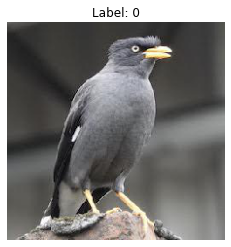

In [ ]:
n = 1
img = x_train[n]
label = target[n]
plt.imshow(img)
plt.title(f"Label: {label }")
plt.axis('off');

看來沒有什麼意外, 就是個鳥圖。我們用 ResNetV2 的預處理再看一次這張鳥圖。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

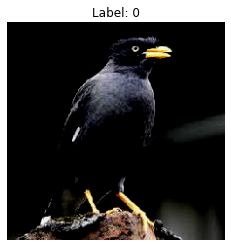

In [ ]:
xp = preprocess_input(img.copy())
plt.imshow(xp)
plt.title(f"Label: {label}")
plt.axis('off');

In [ ]:
print(f"預處裡前的資料範圍: ({x.min()}, {x.max()})")
print(f"預處裡前的資料範圍: ({xp.min()}, {xp.max()})")

預處裡前的資料範圍: (0.0, 1.0)
預處裡前的資料範圍: (-1.0, 1.0)


標籤的資料就是 0, 1, 2 這三個數字，每一張圖片的標籤就是這其中的一個數字。

In [ ]:
target

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

做 one-hot enconding。

In [ ]:
y_train = to_categorical(target, 3)

In [ ]:
print(y_train[n])

[1. 0. 0.]


### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識八哥, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global average pooling), 這本來該我們自己做, 但是 `tf.Keras` 是善良無比的幫我們做好。只要下個參數 `pooling="avg"`)。

In [ ]:
resnet = ResNet50V2(include_top=False, pooling="avg")

再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後一層...

In [ ]:
model = Sequential()

In [ ]:
model.add(resnet)

In [ ]:
model.add(Dense(3, activation='softmax'))

我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [ ]:
resnet.trainable = False

#### 欣賞我們的神經網路

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法。

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

我們可以發現原來有超過兩千萬個參數, 經我們偷來, 不是, 借來以後, 只有 6,147 個參數要調。

### 4. 訓練 fit

這裡我們全部的資料也只有 9 筆, 所以 `batch_size` 就選擇 9 了...

In [ ]:
model.fit(x_train, y_train, batch_size=9, epochs=10)

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.4680 - accuracy: 0.2222
Epoch 2/10
1/1 [==============================] - 0s 94ms/step - loss: 1.1931 - accuracy: 0.4444
Epoch 3/10
1/1 [==============================] - 0s 89ms/step - loss: 0.9806 - accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 0s 93ms/step - loss: 0.8332 - accuracy: 0.5556
Epoch 5/10
1/1 [==============================] - 0s 89ms/step - loss: 0.7344 - accuracy: 0.7778
Epoch 6/10
1/1 [==============================] - 0s 89ms/step - loss: 0.6543 - accuracy: 0.8889
Epoch 7/10
1/1 [==============================] - 0s 86ms/step - loss: 0.5742 - accuracy: 0.8889
Epoch 8/10
1/1 [==============================] - 0s 84ms/step - loss: 0.4925 - accuracy: 0.8889
Epoch 9/10
1/1 [==============================] - 0s 84ms/step - loss: 0.4161 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3512 - accuracy: 1.0000


### 5. 預測

對了, 為何這次我們沒有切測試一一資料呢? 那是因為畢竟我們每張八哥只有 3 張照片。我們可以看一下訓練成果。

In [ ]:
y_predict = np.argmax(model.predict(x_train), -1)

In [ ]:
y_predict

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

好奇的話比較一下正確答案。

In [ ]:
target

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

或是用 model.evaluate 看一下模型表現得如何

In [ ]:
loss, acc = model.evaluate(x_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

1/1 [==============================] - 1s 1s/step - loss: 0.3000 - accuracy: 1.0000
Loss: 0.30003008246421814
Accuracy: 1.0


### 6. 用 `gradio` 打造八哥辨識 web app!

In [ ]:
!pip install gradio
import gradio as gr

#### 三種八哥的 `labels`

In [ ]:
labels = ["白尾八哥", "家八哥", "(土)八哥"]

注意現在主函數和我們做辨識 Cooper 的例子很像, 只是現在我們只有三個種類。而且是我們的 `model`!

In [ ]:

def classify_image(inp):
    inp = inp.reshape((-1, 256, 256, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(3)}

In [ ]:
image = gr.inputs.Image(shape=(256, 256), label="八哥照片")
label = gr.outputs.Label(num_top_classes=3, label="AI辨識結果")
some_text="我能辨識(土)八哥、家八哥、白尾八哥。找張八哥照片來考我吧!"

In [ ]:
import cv2
sample_images = []
for idx, img in enumerate(data):
    cv2.imwrite(f"myna_{idx}.png", img)
    sample_images.append(f"myna_{idx}.png")

In [ ]:
gr.Interface(fn=classify_image, 
             inputs=image, 
             outputs=label,
             title="AI 八哥辨識機",
             description=some_text,
             examples=sample_images).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://56718.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7ff0eebaca50>,
 'http://127.0.0.1:7860/',
 'https://56718.gradio.app')